In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# No animal video

In [194]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def get_2D_map_estimate(posterior, decoder):
    map_position_ind = (
        posterior.where(decoder.is_track_interior_).argmax(
            "position", skipna=True).values
    )
    try:
        bin_center_2D_position = decoder.place_bin_center_2D_position_
    except AttributeError:
        bin_center_2D_position = np.asarray(
            decoder
            .place_bin_centers_nodes_df_
            .loc[:, ["x_position", "y_position"]])

        
    return bin_center_2D_position[map_position_ind]


def make_movie(results, data, classifier,
               movie_name='video_name.mp4'):
    
    
    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    map_position = get_2D_map_estimate(posterior, classifier)
    
    bodyparts_to_rgb = {
        'nose': (46, 49, 146),
        'tail': (0, 174, 239), 
        'tailBase': (0, 174, 239),
        'tailMid': (0, 174, 239),
        'tailTip': (0, 174, 239),
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
        'hindpawL': (255, 0, 255),
        'hindpawR': (195, 0, 23)
    }
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    plt.gca().set_xlabel('x-position', fontsize=24)
    plt.gca().set_ylabel('y-position', fontsize=24)

    ax.plot(data['position_info'].nose_x.values,
            data['position_info'].nose_y.values,
            color='lightgrey', alpha=0.5, label='all positions')
    
    ax.set_xlim(data['position_info'].nose_x.min() - 1,
                data['position_info'].nose_x.max() + 1)
    ax.set_ylim(data['position_info'].nose_y.min() + 1,
                data['position_info'].nose_y.max() + 1)
    
    bodyparts_dot = {}
    for bodypart, color in bodyparts_to_rgb.items():
        bodyparts_dot[bodypart] = plt.scatter(
            [], [], s=200, zorder=102, color=np.asarray(color)/255,
            label=bodypart)

    map_dot = plt.scatter([], [], s=200, zorder=102, color='green',
                          label='Decoded position')
    map_line, = plt.plot([], [], 'green', linewidth=3)
    
    vmax = np.percentile(posterior.values, 99)
    plt.gca().set_xlabel('x-position', fontsize=24)
    plt.gca().set_ylabel('y-position', fontsize=24)

    n_frames = posterior.shape[0]

    def _update_plot(time_ind):
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)

        for bodypart_name, bodypart_dot in bodyparts_dot.items():
            try:
                bodypart_dot.set_offsets(
                    np.asarray(
                        position_info[[f'{bodypart_name}_x', f'{bodypart_name}_y']]
                        .iloc[time_ind]))
            except KeyError:
                pass

        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0],
                          map_position[time_slice, 1])

        plt.gca().set_xlabel('x-position')
        plt.gca().set_ylabel('y-position')

        return tuple(bodyparts_dot.values())

    plt.gca().set_xlabel('x-position', fontsize=24)
    plt.gca().set_ylabel('y-position', fontsize=24)
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=50, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie

In [192]:
time_ind = 0


(640, 692)

In [186]:
cv2.imread('video_images/20190829_Jaq_16_wtrack00000.png').shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [4]:
from src.load_data import load_data


epoch_key = 'Jaq', 3, 16
animal, day, epoch = epoch_key
data = load_data(epoch_key)

In [5]:
import xarray as xr
from src.parameters import ANIMALS

results = xr.open_dataset(
    f'{ANIMALS["Jaq"].directory}/decoding_clusterless/'
    f'{animal}_{day}_{epoch}_cv_classifier_clusterless_vel_0_nose_alltime5x_results.nc')
results

<xarray.Dataset>
Dimensions:                                    (position: 161, state: 2, time: 452325)
Coordinates:
  * time                                       (time) float64 2.239e+04 ... 2...
  * position                                   (position) float64 1.249 ... 4...
  * state                                      (state) object 'random_walk' '...
Data variables: (12/13)
    likelihood                                 (time, state, position) float64 ...
    causal_posterior                           (time, state, position) float64 ...
    acausal_posterior                          (time, state, position) float64 ...
    rel_distance_from_animal_position_causal   (time) float64 ...
    rel_distance_from_animal_position_acausal  (time) float64 ...
    hpd_threshold_95_causal                    (time) float64 ...
    ...                                         ...
    hpd_threshold_95_acausal                   (time) float64 ...
    hpd_threshold_50_acausal                   (time) float64 ...
    credible_interval_95_causal                (time) float64 ...
    credible_interval_50_causal                (time) float64 ...
    credible_interval_95_acausal               (time) float64 ...
    credible_interval_50_acausal               (time) float64 ...

In [6]:
from replay_trajectory_classification import ClusterlessClassifier

classifier = ClusterlessClassifier.load_model(
    f'{ANIMALS["Jaq"].directory}/decoding_clusterless/'
    f'{animal}_{day}_{epoch}_cv_classifier_clusterless_nose.pkl')

In [7]:
time_slice = slice(22559.0, 22560.5)

In [8]:
posterior = results.causal_posterior.sel(time=time_slice).sum('state')

In [9]:
import numpy as np

position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])

position_info

nose_x     nose_y   nose_vel  tailBase_x  tailBase_y  \
time                                                                    
22559.000875  92.571198  46.753462  68.572369   90.156887   57.143671   
22559.002875  92.458382  46.751381  68.428223   90.204781   57.147636   
22559.004875  92.345566  46.749300  68.284077   90.252674   57.151602   
22559.006875  92.232750  46.747219  68.139931   90.300568   57.155567   
22559.008875  92.116358  46.742702  68.015169   90.355042   57.167459   
...                 ...        ...        ...         ...         ...   
22560.490875   4.515668  36.919409  61.539837   13.582660   56.973213   
22560.492875   4.518609  36.812413  61.576796   13.494793   56.974766   
22560.494875   4.521550  36.705418  61.613754   13.406925   56.976318   
22560.496875   4.516559  36.591121  61.657947   13.309437   56.981211   
22560.498875   4.511568  36.476824  61.702139   13.211949   56.986103   

              tailBase_vel  tailMid_x  tailMid_y  tailMid_vel  tailTip_x  ...  \
time                                                                      ...   
22559.000875     32.136237  83.686361  56.637516    38.599466  76.112373  ...   
22559.002875     32.374057  83.763958  56.644264    38.786484  76.153282  ...   
22559.004875     32.611877  83.841555  56.651012    38.973501  76.194191  ...   
22559.006875     32.849697  83.919151  56.657761    39.160519  76.235100  ...   
22559.008875     33.087880  83.980097  56.661694    39.353728  76.260778  ...   
...                    ...        ...        ...          ...        ...  ...   
22560.490875     63.557684  20.669572  55.462358    57.857767  28.787851  ...   
22560.492875     63.629245  20.586874  55.483829    57.923797  28.673164  ...   
22560.494875     63.700806  20.504177  55.505299    57.989826  28.558477  ...   
22560.496875     63.779522  20.420280  55.528796    58.068255  28.444456  ...   
22560.498875     63.858238  20.336382  55.552294    58.146685  28.330435  ...   

              track_segment_id  projected_x_position  projected_y_position  \
time                                                                         
22559.000875               0.0             92.659757             53.793146   
22559.002875               0.0             92.546985             53.794565   
22559.004875               0.0             92.434214             53.795984   
22559.006875               0.0             92.321442             53.797402   
22559.008875               0.0             92.205125             53.798866   
...                        ...                   ...                   ...   
22560.490875               1.0              5.885197             36.901274   
22560.492875               1.0              5.883781             36.794337   
22560.494875               1.0              5.882365             36.687399   
22560.496875               1.0              5.880851             36.573056   
22560.498875               1.0              5.879337             36.458713   

                arm_name  labeled_segments  from_well  to_well      task  \
time                                                                       
22559.000875  Center Arm               359     Center    Right  Outbound   
22559.002875  Center Arm               359     Center    Right  Outbound   
22559.004875  Center Arm               359     Center    Right  Outbound   
22559.006875  Center Arm               359     Center    Right  Outbound   
22559.008875  Center Arm               359     Center    Right  Outbound   
...                  ...               ...        ...      ...       ...   
22560.490875    Left Arm               359     Center    Right  Outbound   
22560.492875    Left Arm               359     Center    Right  Outbound   
22560.494875    Left Arm               359     Center    Right  Outbound   
22560.496875    Left Arm               359     Center    Right  Outbound   
22560.498875    Left Arm               359     Center    Right  Outbound   

         

In [ ]:
make_movie(results, data, classifier,
            movie_name='test1.mp4')

In [14]:
import cv2

video_filename = "/stelmo/abhilasha/animals/Jaq/raw/20190829/20190829_Jaq_16_wtrack.1.h264"
video = cv2.VideoCapture(video_filename)

video.set?

Docstring:
set(propId, value) -> retval
.   @brief Sets a property in the VideoCapture.
.   
.       @param propId Property identifier from cv::VideoCaptureProperties (eg. cv::CAP_PROP_POS_MSEC, cv::CAP_PROP_POS_FRAMES, ...)
.       or one from @ref videoio_flags_others
.       @param value Value of the property.
.       @return `true` if the property is supported by backend used by the VideoCapture instance.
.       @note Even if it returns `true` this doesn't ensure that the property
.       value has been accepted by the capture device. See note in VideoCapture::get()
Type:      builtin_function_or_method


In [64]:
from src.load_data import get_position_info

uninterpolated_position_info = get_position_info(
    epoch_key, skip_linearization=True)
video_time = np.asarray(uninterpolated_position_info.index / np.timedelta64(1, 's'))
video_time_ind = np.digitize(posterior.time, video_time[1:-1])
video_time_ind

array([21176, 21176, 21176, 21176, 21177, 21177, 21177, 21177, 21178,
       21178, 21178, 21178, 21179, 21179, 21179, 21179, 21180, 21180,
       21180, 21180, 21181, 21181, 21181, 21181, 21182, 21182, 21182,
       21182, 21183, 21183, 21183, 21183, 21184, 21184, 21184, 21184,
       21185, 21185, 21185, 21185, 21186, 21186, 21186, 21186, 21187,
       21187, 21187, 21187, 21188, 21188, 21188, 21188, 21189, 21189,
       21189, 21189, 21190, 21190, 21190, 21190, 21191, 21191, 21191,
       21191, 21192, 21192, 21192, 21192, 21193, 21193, 21193, 21193,
       21194, 21194, 21194, 21194, 21195, 21195, 21195, 21195, 21196,
       21196, 21196, 21196, 21197, 21197, 21197, 21197, 21198, 21198,
       21198, 21198, 21199, 21199, 21199, 21199, 21200, 21200, 21200,
       21200, 21201, 21201, 21201, 21201, 21202, 21202, 21202, 21202,
       21203, 21203, 21203, 21203, 21204, 21204, 21204, 21204, 21205,
       21205, 21205, 21205, 21206, 21206, 21206, 21206, 21207, 21207,
       21207, 21207,

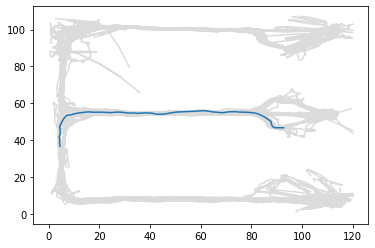

In [78]:
plt.plot(uninterpolated_position_info.nose_x,
         uninterpolated_position_info.nose_y, color='lightgrey', alpha=0.8)
plt.plot(uninterpolated_position_info.iloc[video_time_ind].nose_x,
         uninterpolated_position_info.iloc[video_time_ind].nose_y)

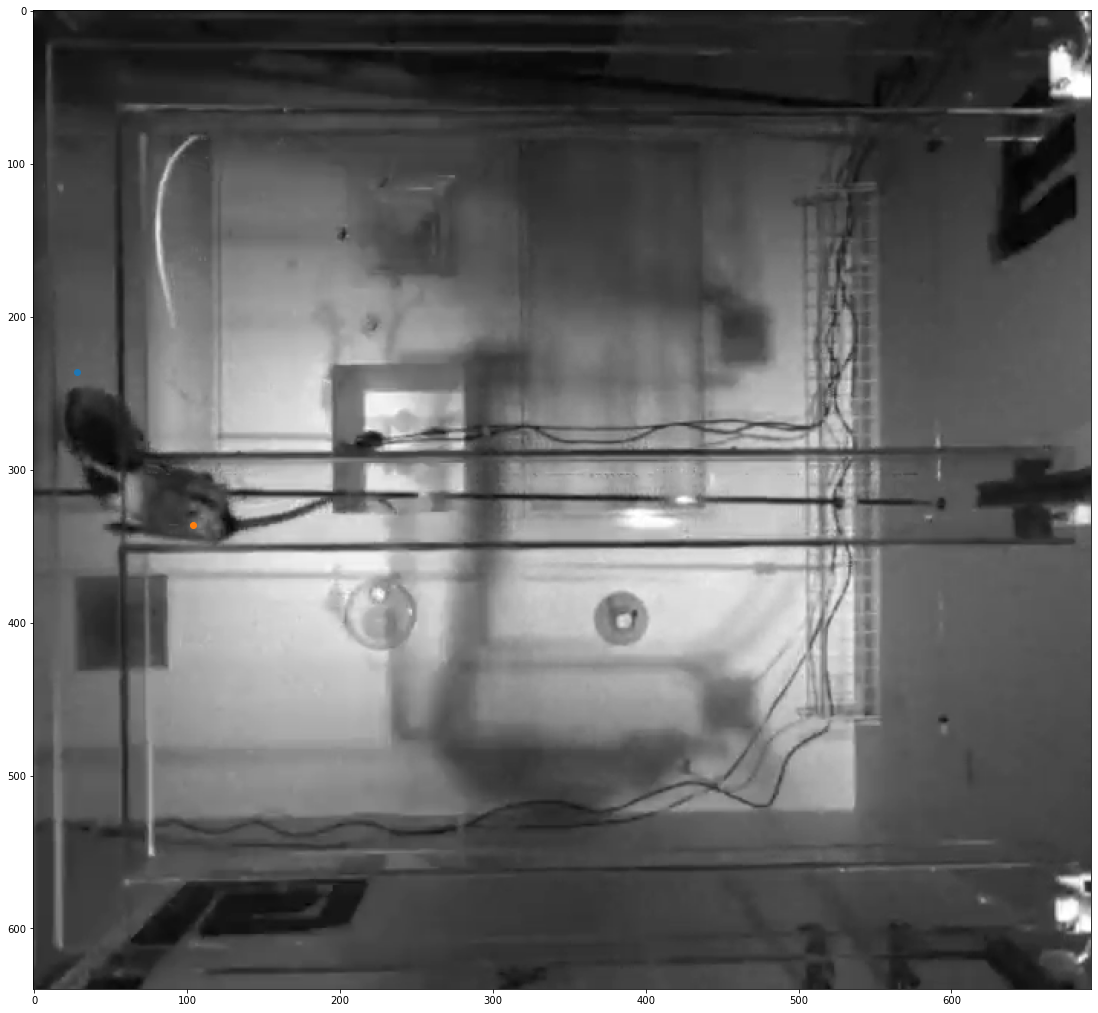

In [141]:
time_ind = 21_353

plt.figure(figsize=(20, 18))
plt.imshow(cv2.imread(f'video_images/20190829_Jaq_16_wtrack{time_ind:05d}.png'))
plt.scatter(uninterpolated_position_info.iloc[time_ind].nose_x / cm_to_pixels[0],
            uninterpolated_position_info.iloc[time_ind].nose_y / cm_to_pixels[1])
plt.scatter(uninterpolated_position_info.iloc[time_ind].tailBase_x / cm_to_pixels[0],
            uninterpolated_position_info.iloc[time_ind].tailBase_y / cm_to_pixels[1])

In [148]:
21_353 / 125 / 60

2.847066666666667

In [149]:
60 * .84706

50.8236

In [115]:
frame_size

(692, 640)

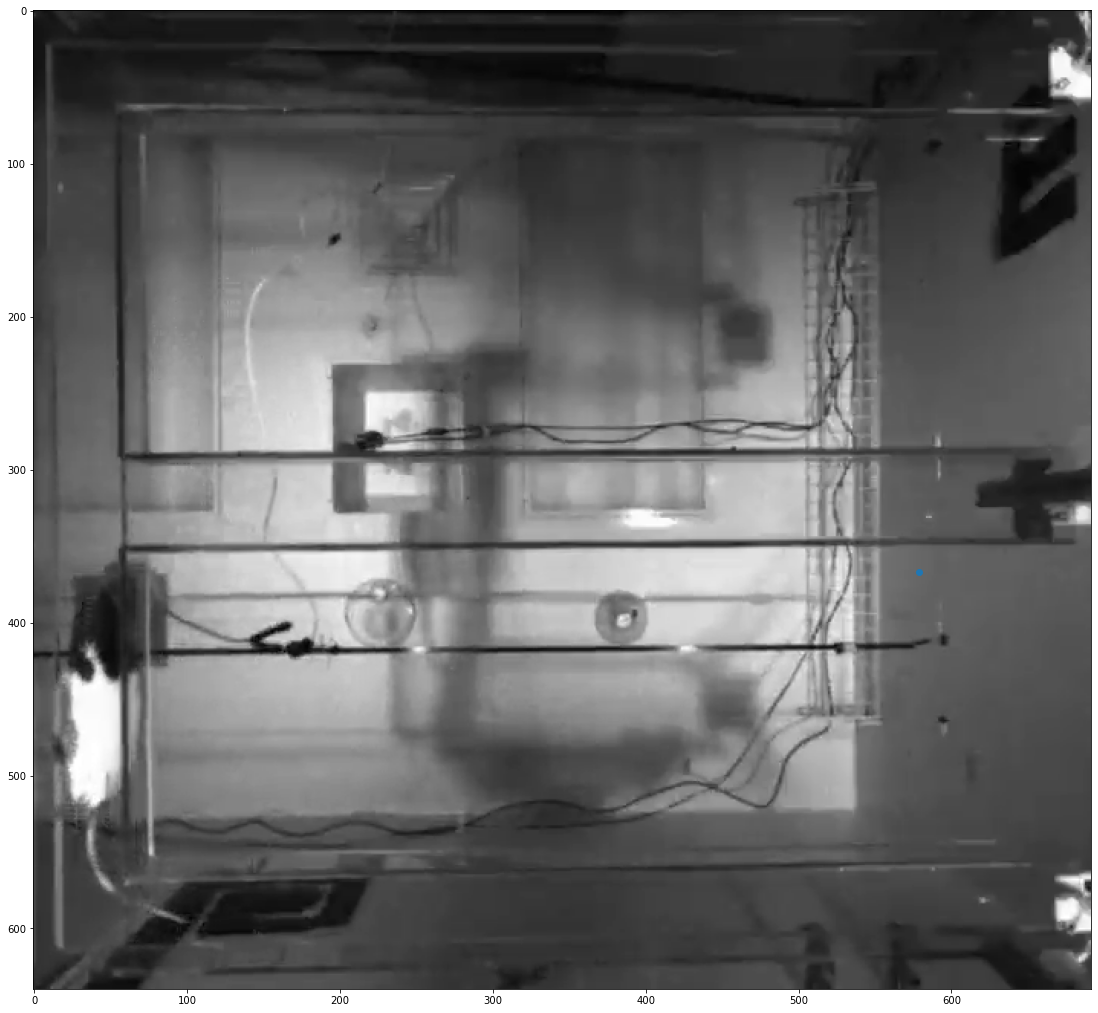

In [96]:
cm_to_pixels = np.asarray([0.1602, 0.1712])
frame_size = int(video.get(3)), int(video.get(4))


time_ind = 21176
video.set(cv2.CAP_PROP_POS_FRAMES, time_ind)
is_grabbed, frame = video.read()
if is_grabbed:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 18))
    plt.imshow(frame)
    
    plt.scatter(uninterpolated_position_info.iloc[time_ind].nose_x / cm_to_pixels[0],
                frame_size[1] - uninterpolated_position_info.iloc[time_ind].nose_y / cm_to_pixels[1])

In [98]:
!ffmpeg -i "/stelmo/abhilasha/animals/Jaq/raw/20190829/20190829_Jaq_16_wtrack.1.h264" -f image2 "video_images/20190829_Jaq_16_wtrack%05d.png"

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavforma

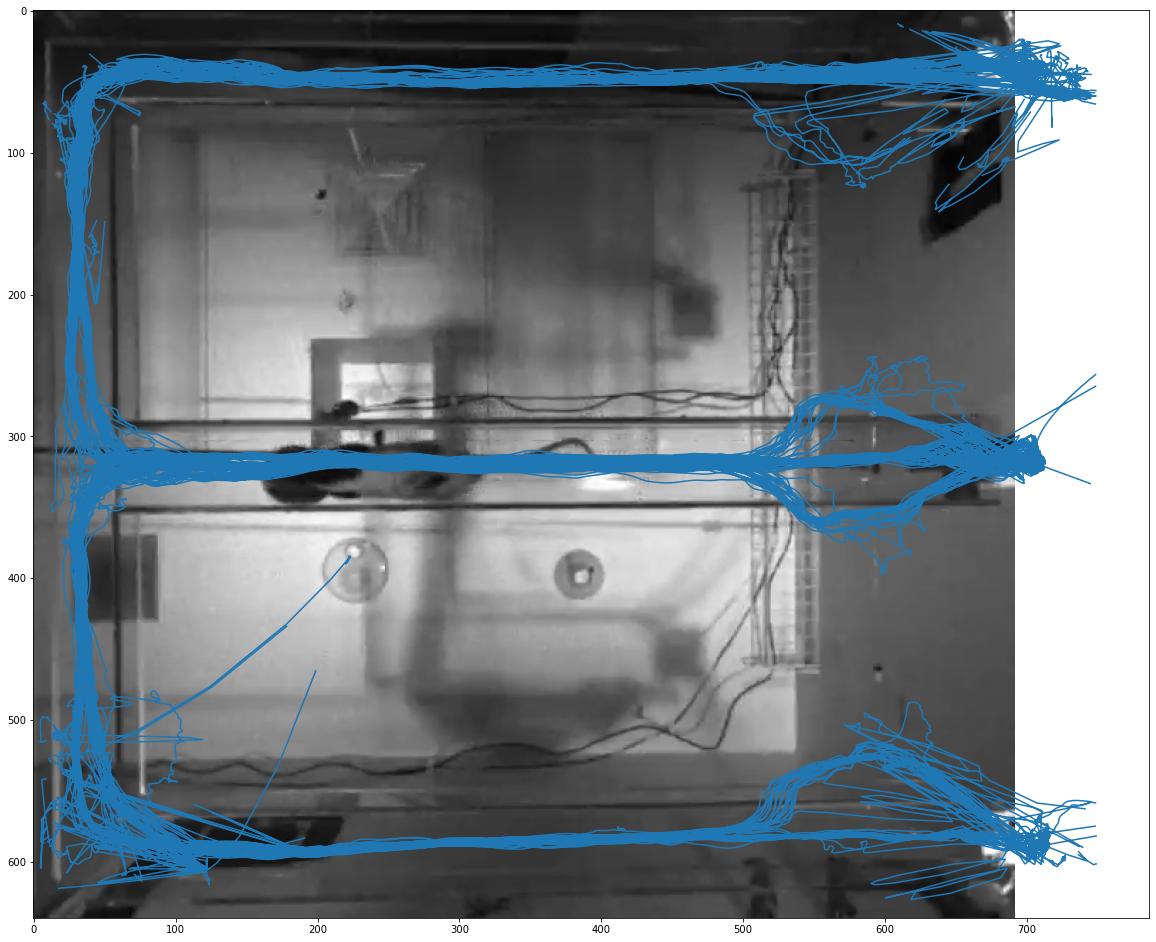

In [127]:
plt.figure(figsize=(20, 18))
plt.imshow(cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[time_ind]:05d}.png'))
plt.plot(uninterpolated_position_info.nose_x / cm_to_pixels[0], uninterpolated_position_info.nose_y / cm_to_pixels[1])

In [220]:
extent = (-0.5 * cm_to_pixels[0], (frame_size[0] - 0.5) * cm_to_pixels[0], -0.5 * cm_to_pixels[1], (frame_size[1] - 0.5) * cm_to_pixels[1])
extent

(-0.0801, 110.7783, -0.0856, 109.4824)

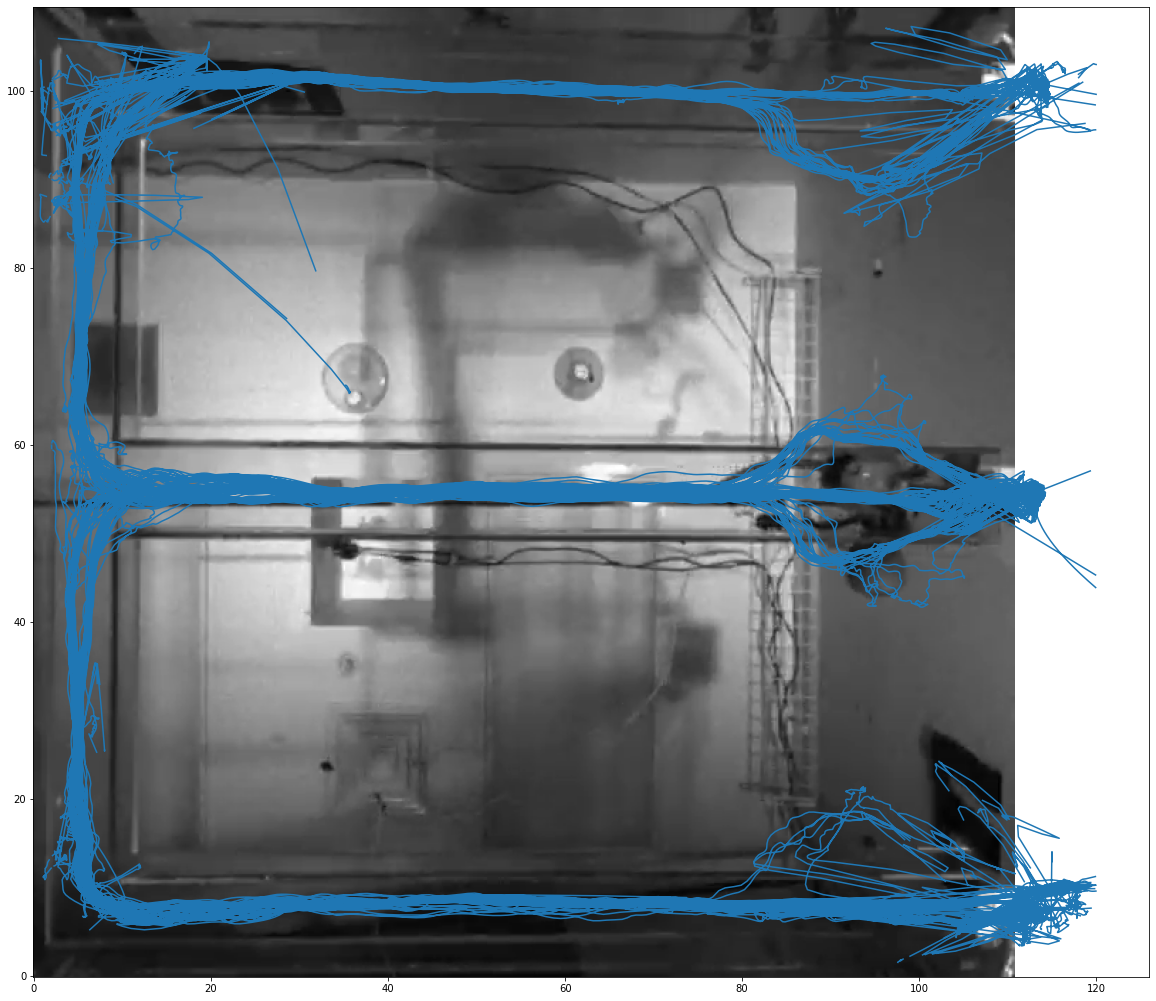

In [221]:
time_ind = 0
plt.figure(figsize=(20, 18))
plt.imshow(cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[time_ind]:05d}.png'), origin='lower', extent=extent)
plt.plot(uninterpolated_position_info.nose_x, uninterpolated_position_info.nose_y)

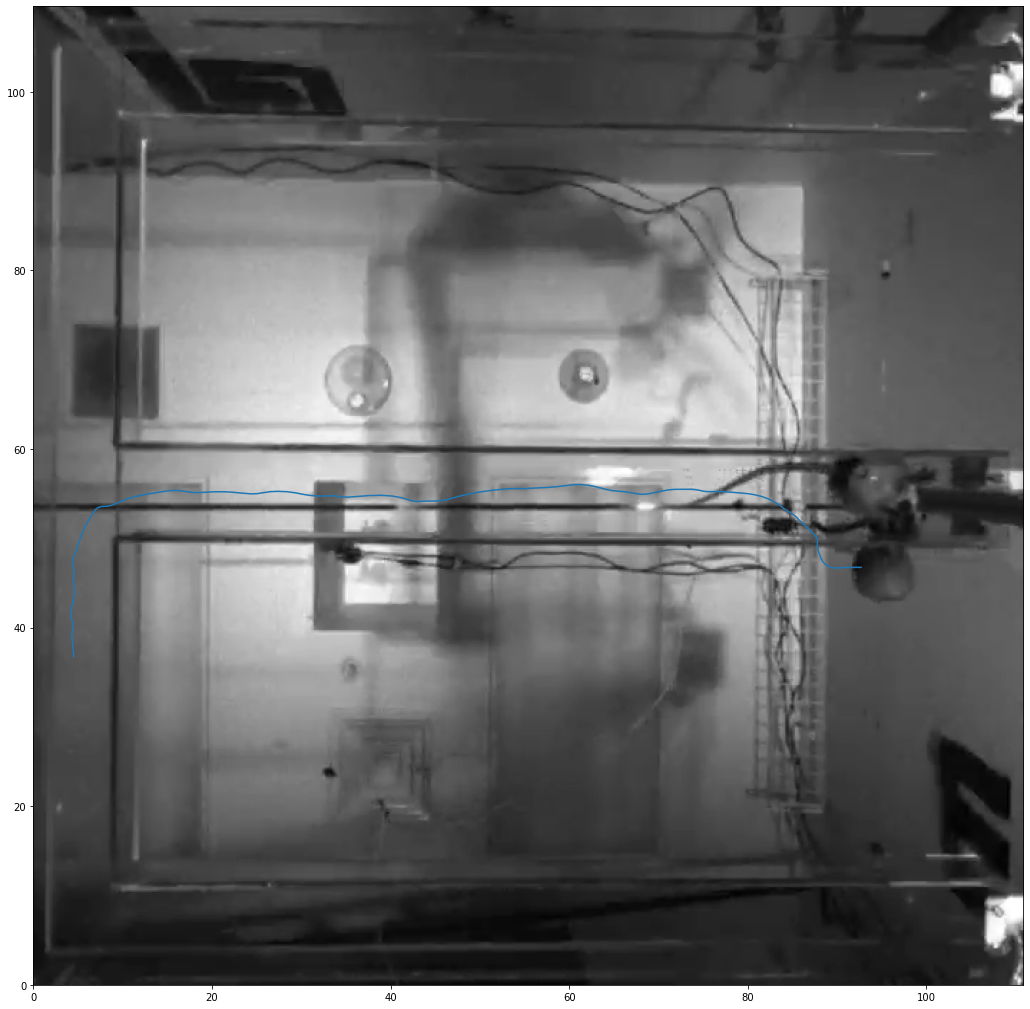

In [231]:
time_ind = 0

extent = (0, frame_size[0] * cm_to_pixels[0], 0, frame_size[1] * cm_to_pixels[1])

plt.figure(figsize=(20, 18))
plt.imshow(cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[time_ind]:05d}.png'), origin='lower', extent=extent)
plt.plot(uninterpolated_position_info.iloc[video_time_ind].nose_x,
         uninterpolated_position_info.iloc[video_time_ind].nose_y)

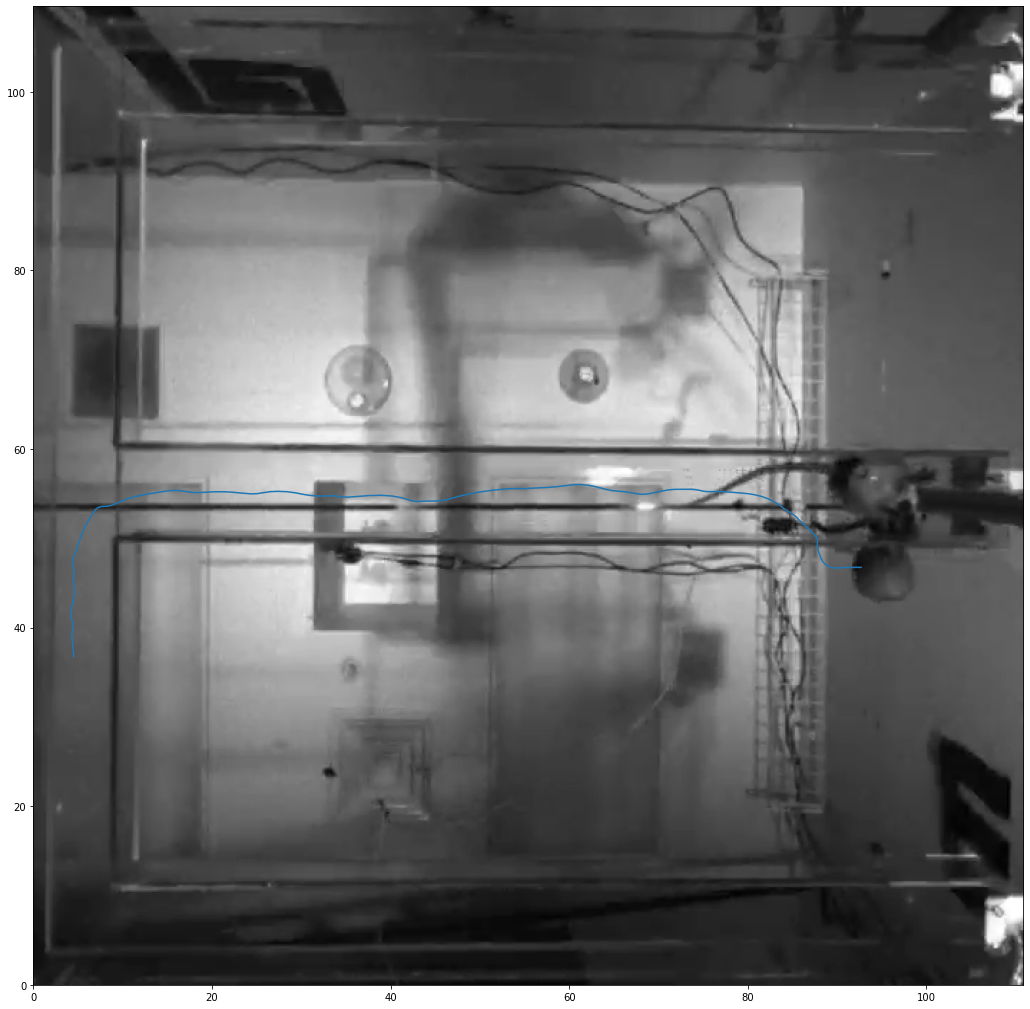

In [241]:
time_ind = 0

extent = (0, frame_size[0] * cm_to_pixels[0], 0, frame_size[1] * cm_to_pixels[1])

plt.figure(figsize=(20, 18))
plt.imshow(cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[time_ind]:05d}.png'), origin='lower', extent=extent)
plt.plot(uninterpolated_position_info.iloc[video_time_ind].nose_x,
         uninterpolated_position_info.iloc[video_time_ind].nose_y)


In [364]:
def make_movie_with_video(time_slice, results, data, classifier, video_time,
                          cm_to_pixels, movie_name='video_name.mp4'):
    
    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    
    bodyparts_to_rgb = {
        'nose': (46, 49, 146),
        'tail': (0, 174, 239), 
        'tailBase': (0, 174, 239),
        'tailMid': (0, 174, 239),
        'tailTip': (0, 174, 239),
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
        'hindpawL': (255, 0, 255),
        'hindpawR': (195, 0, 23)
    }
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=125//8, metadata=dict(artist='Me'), bitrate=1800)

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    bodyparts_dot = {}
    for bodypart, color in bodyparts_to_rgb.items():
        bodyparts_dot[bodypart] = plt.scatter(
            [], [], s=200, zorder=102, color=np.asarray(color)/255,
            label=bodypart)

    map_dot = plt.scatter([], [], s=200, zorder=102, color='green',
                          label='Decoded position')
    map_line, = plt.plot([], [], 'green', linewidth=3)
    vmax = np.percentile(posterior.values, 99)
    
    frame_size = cv2.imread(
        f'video_images/20190829_Jaq_16_wtrack{video_time_ind[0]:05d}.png').shape[:2]
    n_frames = posterior.shape[0]

    def _update_plot(time_ind):
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)

        for bodypart_name, bodypart_dot in bodyparts_dot.items():
            try:
                bodypart_dot.set_offsets(
                    np.asarray(
                        position_info[[f'{bodypart_name}_x', f'{bodypart_name}_y']]
                        .iloc[time_ind]) / cm_to_pixels)
            except KeyError:
                pass

        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0],
                          map_position[time_slice, 1])
        plt.imshow(
            cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[time_ind]:05d}.png'),
            zorder=-1)

        return tuple(bodyparts_dot.values())
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=50, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie

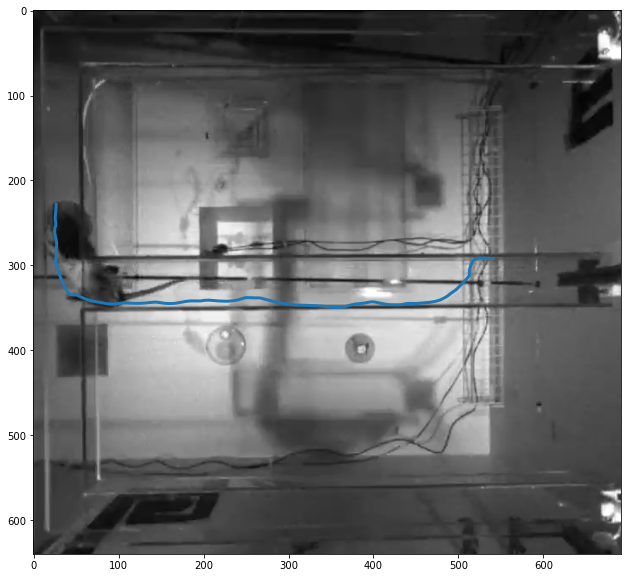

In [363]:
plt.figure(figsize=(18,10))

frame_size = cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[0]:05d}.png').shape[:2]
plt.imshow(
    cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[-1]:05d}.png'),
    zorder=-1,)

posterior = results.causal_posterior.sel(time=time_slice).sum('state')
video_time_ind = np.digitize(posterior.time, video_time[1:-1])

position_info = (data['position_info']
             .set_index(data['position_info'].index / np.timedelta64(1, 's'))
             .loc[time_slice])

position_info2 = (uninterpolated_position_info
             .set_index(uninterpolated_position_info.index / np.timedelta64(1, 's'))
             .loc[time_slice])

map_position = get_2D_map_estimate(posterior, classifier)
plt.plot(position_info.nose_x / cm_to_pixels[1],
         position_info.nose_y / cm_to_pixels[0],
         linewidth=3)


In [357]:
cm_to_pixels

array([0.1602, 0.1712])

In [242]:
extent=[horizontal_min,horizontal_max,vertical_min,vertical_max]. 

110.8584

In [253]:
cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[0]:05d}.png').shape[:2]

(640, 692)

In [368]:
!ffmpeg -framerate 125 -i "/stelmo/abhilasha/animals/Jaq/raw/20190829/20190829_Jaq_16_wtrack.1.h264" -c copy "20190829_Jaq_16_wtrack.1.mp4"

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1609680890771/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavforma

In [254]:
import cv2

video = cv2.VideoCapture(video_filename)

int(video.get(3)), int(video.get(4))


(692, 640)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\x14\xc8mdat\x0…

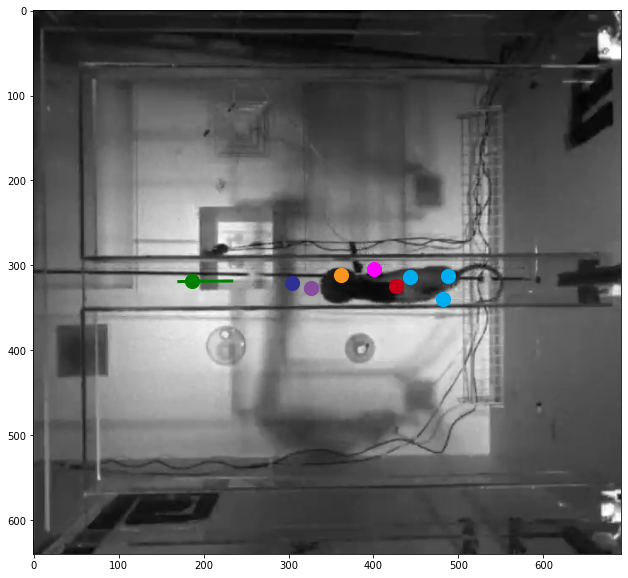

In [367]:
from ipywidgets import Video

time_slice = slice(22559.6, 22559.7)

movie_name = 'test_with_animal_video2.mp4'
make_movie_with_video(time_slice, results, data, classifier, video_time, cm_to_pixels,
                      movie_name=movie_name);

Video.from_file(movie_name)

In [267]:
from scipy.io import loadmat

forvideo_data = loadmat('Jaq_d3_ep16_forvideo.mat')

forvideo_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ahead_behind_dist_smooth', 'forelimbL_plants', 'forelimbL_velocity', 'forelimbR_plants', 'forelimbR_velocity', 'posteriorts_wtrack'])

In [270]:
forvideo_data['forelimbL_plants'].shape, forvideo_data['forelimbL_velocity'].shape

((360, 1), (113029, 1))

In [272]:
results.time.shape

(452325,)

In [273]:
data['position_info'].shape

(452325, 39)

In [274]:
uninterpolated_position_info.shape

(113030, 28)

In [282]:
np.digitize(forvideo_data['forelimbL_plants'].squeeze()[1:-1],
            np.asarray(results.time))

array([ 16528,  16700,  16820,  16944,  17068,  17220,  17384,  28798,
        28922,  29022,  29154,  29274,  29390,  47140,  47408,  47544,
        47648,  47756,  47864,  48016,  48276,  60598,  60734,  60834,
        60934,  61046,  61154,  61258,  61398,  61582,  74040,  74216,
        74348,  74452,  74560,  75024,  84751,  84847,  84927,  85007,
        85115,  85279,  85383,  85495,  85611,  85719,  85887,  94910,
        95010,  95162,  95298,  95402,  95506,  95962, 106320, 106396,
       106488, 106568, 106664, 106760, 106860, 106976, 107056, 107164,
       107316, 114755, 114923, 115067, 115175, 115275, 115367, 115475,
       115707, 127354, 127582, 127682, 127782, 127878, 127986, 128118,
       128266, 128374, 137888, 138000, 138112, 138220, 138344, 138540,
       138644, 147823, 147903, 147999, 148099, 148199, 148299, 148411,
       148535, 148743, 157418, 157562, 157670, 157782, 157882, 157990,
       158130, 158418, 158506, 168601, 168709, 168809, 168909, 169009,
      

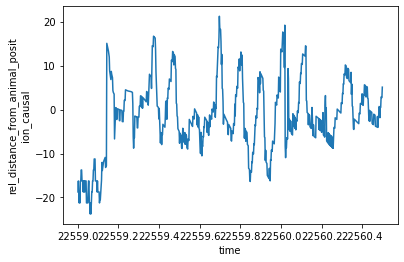

In [291]:
results.sel(time=time_slice).rel_distance_from_animal_position_causal.plot(x='time')

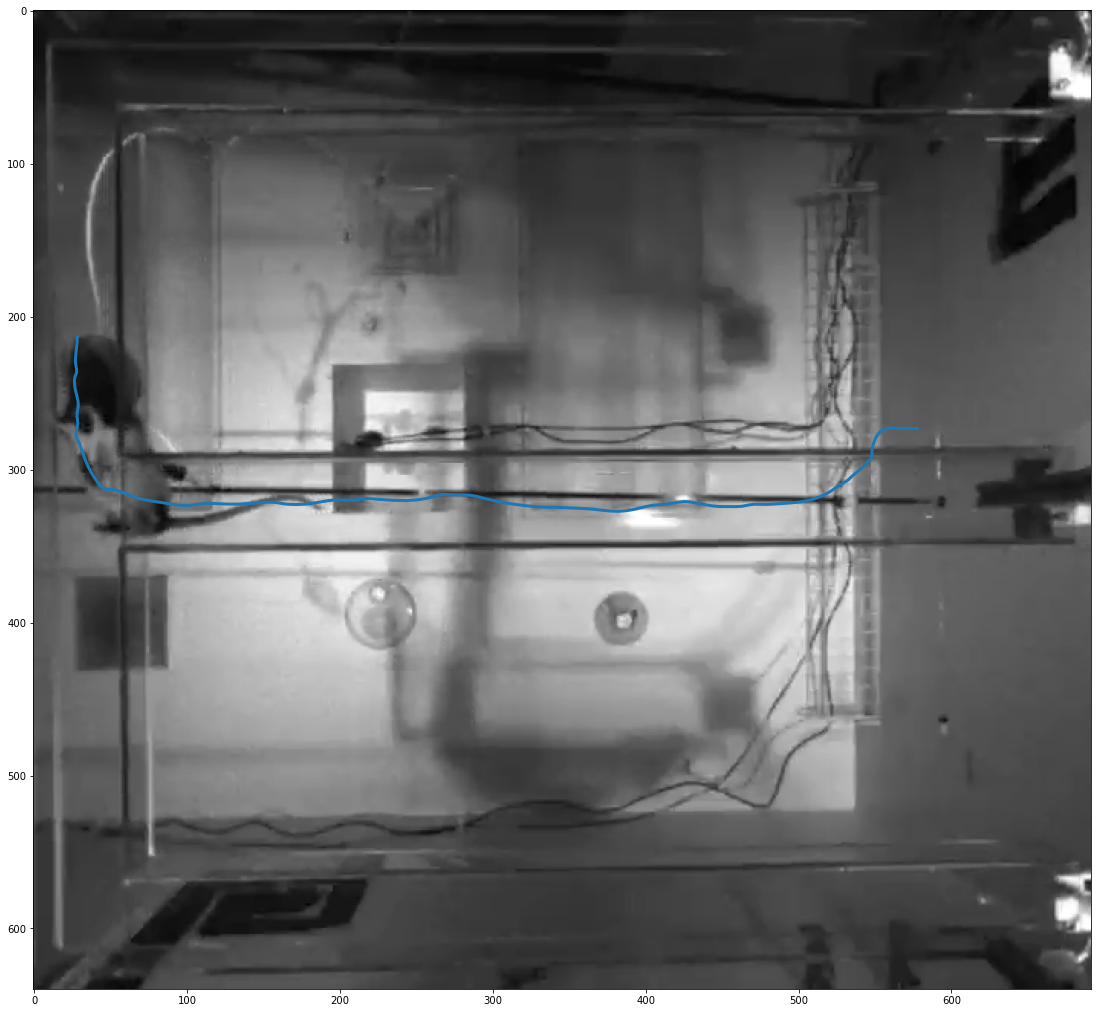

In [373]:
import cv2

video_mp4 = cv2.VideoCapture('20190829_Jaq_16_wtrack.1.mp4')

video_mp4.set(1, video_time_ind[-1])
is_grabbed, frame = video_mp4.read()
if is_grabbed:
    plt.figure(figsize=(20, 18))
    plt.imshow(frame)
    position_info2 = (uninterpolated_position_info
             .set_index(uninterpolated_position_info.index / np.timedelta64(1, 's'))
             .loc[time_slice])
    plt.plot(position_info.nose_x / cm_to_pixels[0],
             position_info.nose_y / cm_to_pixels[1],
             linewidth=3)

In [374]:
def make_movie_with_video2(time_slice, results, data, classifier, video_time,
                          cm_to_pixels, movie_name='video_name.mp4'):
    
    video_mp4 = cv2.VideoCapture('20190829_Jaq_16_wtrack.1.mp4')
    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    
    bodyparts_to_rgb = {
        'nose': (46, 49, 146),
        'tail': (0, 174, 239), 
        'tailBase': (0, 174, 239),
        'tailMid': (0, 174, 239),
        'tailTip': (0, 174, 239),
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
        'hindpawL': (255, 0, 255),
        'hindpawR': (195, 0, 23)
    }
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=125//8, metadata=dict(artist='Me'), bitrate=1800)

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    bodyparts_dot = {}
    for bodypart, color in bodyparts_to_rgb.items():
        bodyparts_dot[bodypart] = plt.scatter(
            [], [], s=200, zorder=102, color=np.asarray(color)/255,
            label=bodypart)

    map_dot = plt.scatter([], [], s=200, zorder=102, color='green',
                          label='Decoded position')
    map_line, = plt.plot([], [], 'green', linewidth=3)
    vmax = np.percentile(posterior.values, 99)
    n_frames = posterior.shape[0]

    def _update_plot(time_ind):
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)

        for bodypart_name, bodypart_dot in bodyparts_dot.items():
            try:
                bodypart_dot.set_offsets(
                    np.asarray(
                        position_info[[f'{bodypart_name}_x', f'{bodypart_name}_y']]
                        .iloc[time_ind]) / cm_to_pixels)
            except KeyError:
                pass

        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0],
                          map_position[time_slice, 1])
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            plt.imshow(frame, zorder=-1)

        return tuple(bodyparts_dot.values())
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=50, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie

In [ ]:
time_slice = slice(22559.0, 22560.5)

movie_name = 'test_with_animal_video3.mp4'
make_movie_with_video2(time_slice, results, data, classifier, video_time, cm_to_pixels,
                       movie_name=movie_name);

Video.from_file(movie_name)

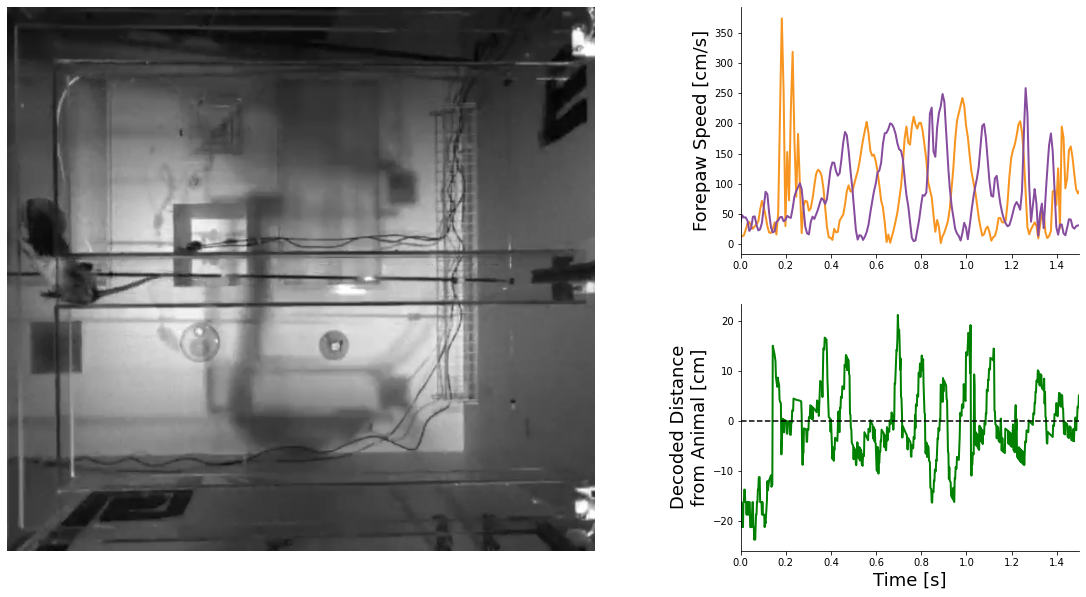

In [379]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(20, 10),
                         gridspec_kw={"width_ratios": [2, 1]},
                         constrained_layout=False);
gs = axes[0, 1].get_gridspec()
for ax in axes[:, 0]:
    ax.remove()
ax_big = fig.add_subplot(gs[:, 0])
ax_big.axis('off')
ax_big.imshow(
    cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[-1]:05d}.png'))


duration = results.sel(time=time_slice).time[-1] - results.sel(time=time_slice).time[0]
bodyparts_to_rgb = {
    'nose': (46, 49, 146),
    'tail': (0, 174, 239), 
    'tailBase': (0, 174, 239),
    'tailMid': (0, 174, 239),
    'tailTip': (0, 174, 239),
    'forepawL': (247, 149, 32),
    'forepawR': (134, 76, 158),
    'hindpawL': (255, 0, 255),
    'hindpawR': (195, 0, 23)
}
axes[0, 1].plot(results.sel(time=time_slice).time - results.sel(time=time_slice).time[0],
    data['position_info']
    .set_index(data['position_info'].index / np.timedelta64(1, 's'))
    .loc[time_slice]
    .forepawL_vel,
    color=np.asarray(bodyparts_to_rgb['forepawL']) / 255,
    linewidth=2
)
axes[0, 1].plot(results.sel(time=time_slice).time - results.sel(time=time_slice).time[0],
    data['position_info']
    .set_index(data['position_info'].index / np.timedelta64(1, 's'))
    .loc[time_slice]
    .forepawR_vel,
    color=np.asarray(bodyparts_to_rgb['forepawR']) / 255,
    linewidth=2,
)
axes[0, 1].set_ylabel('Forepaw Speed [cm/s]', fontsize=18)
axes[0, 1].set_xlim((0, duration))
sns.despine(ax=axes[0, 1])


axes[1, 1].plot(results.sel(time=time_slice).time - results.sel(time=time_slice).time[0],
    results
    .sel(time=time_slice)
    .rel_distance_from_animal_position_causal,
    color='green',
    linewidth=2,
)
axes[1, 1].axhline(0, color='black', linestyle='--')
axes[1, 1].set_ylabel('Decoded Distance\nfrom Animal [cm]', fontsize=18)
axes[1, 1].set_xlabel('Time [s]', fontsize=18)
axes[1, 1].set_xlim((0, duration))
sns.despine(ax=axes[1, 1])

In [544]:
def make_movie_with_video3(time_slice, results, data, classifier, video_time,
                          cm_to_pixels, movie_name='video_name.mp4', sampling_frequency=500):
    
    video_mp4 = cv2.VideoCapture('20190829_Jaq_16_wtrack.1.mp4')
    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    ahead_behind_distance = np.asarray(results
                                       .sel(time=time_slice)
                                       .rel_distance_from_animal_position_causal)
    max_ab_distance = np.max(np.abs(ahead_behind_distance))
    duration = results.sel(time=time_slice).time[-1] - results.sel(time=time_slice).time[0]
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    forepawL_speed = np.asarray(data['position_info']
                      .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                      .loc[time_slice]
                      .forepawL_vel)
    forepawR_speed = np.asarray(data['position_info']
                  .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                  .loc[time_slice]
                  .forepawR_vel)
    max_speed = max(forepawL_speed.max(), forepawR_speed.max())
    
    bodyparts_to_rgb = {
        'nose': (46, 49, 146),
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
    }
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=125//8, metadata=dict(artist='Me'), bitrate=1800)

    fig, axes = plt.subplots(2, 2, figsize=(20, 10),
                             gridspec_kw={"width_ratios": [2, 1]},
                             constrained_layout=False);
    gs = axes[0, 1].get_gridspec()
    for ax in axes[:, 0]:
        ax.remove()
    ax_big = fig.add_subplot(gs[:, 0])
    ax_big.axis('off')
    
    bodyparts_dot = {}
    for bodypart, color in bodyparts_to_rgb.items():
        bodyparts_dot[bodypart] = ax_big.scatter(
            [], [], s=200, zorder=102, color=np.asarray(color)/255,
            label=bodypart)

    map_dot = ax_big.scatter([], [], s=200, zorder=102, color='green',
                          label='Decoded position')
    (map_line,) = ax_big.plot([], [], 'green', linewidth=3)
    
    # Axes [0, 1]
    (forepawL_line,) = axes[0, 1].plot([], [], color=np.asarray(bodyparts_to_rgb['forepawL']) / 255, linewidth=2)
    (forepawR_line,) = axes[0, 1].plot([], [], color=np.asarray(bodyparts_to_rgb['forepawR']) / 255, linewidth=2)
    
    axes[0, 1].set_ylabel('Forepaw Speed [cm/s]', fontsize=18)
    axes[0, 1].set_xlim((0, duration))
    axes[0, 1].set_ylim((0, max_speed))
    sns.despine(ax=axes[0, 1])
    
    # Axes [1, 1]
    (ahead_behind_line,) = axes[1, 1].plot([], [], "green", linewidth=2)
    axes[1, 1].axhline(0, color=np.asarray(bodyparts_to_rgb['nose']) / 255, linestyle='--')
    axes[1, 1].set_ylabel('Decoded Distance\nfrom Nose [cm]', fontsize=18)
    axes[1, 1].set_xlabel('Time [s]', fontsize=18)
    axes[1, 1].set_xlim((0, duration))
    axes[1, 1].set_ylim((-max_ab_distance, max_ab_distance))
    sns.despine(ax=axes[1, 1])
    
    vmax = np.percentile(posterior.values, 99)
    n_frames = posterior.shape[0]

    def _update_plot(time_ind):
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)
        
        # Body parts
        for bodypart_name, bodypart_dot in bodyparts_dot.items():
            try:
                bodypart_dot.set_offsets(
                    np.asarray(
                        position_info[[f'{bodypart_name}_x', f'{bodypart_name}_y']]
                        .iloc[time_ind]) / cm_to_pixels)
            except KeyError:
                pass

        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0],
                          map_position[time_slice, 1])
        
        # Video
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            ax_big.imshow(frame, zorder=-1)
            
        # Axes [0, 1]
        forepawL_line.set_data(np.arange(time_ind) / sampling_frequency,
                               forepawL_speed[slice(0, time_ind)])
        forepawR_line.set_data(np.arange(time_ind) / sampling_frequency,
                               forepawR_speed[slice(0, time_ind)])
        # Axes [1, 1]
        ahead_behind_line.set_data(np.arange(time_ind) / sampling_frequency,
                                   ahead_behind_distance[slice(0, time_ind)])

        return tuple(bodyparts_dot.values())

    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=50, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00C\xadYmdat\x00\x00\…

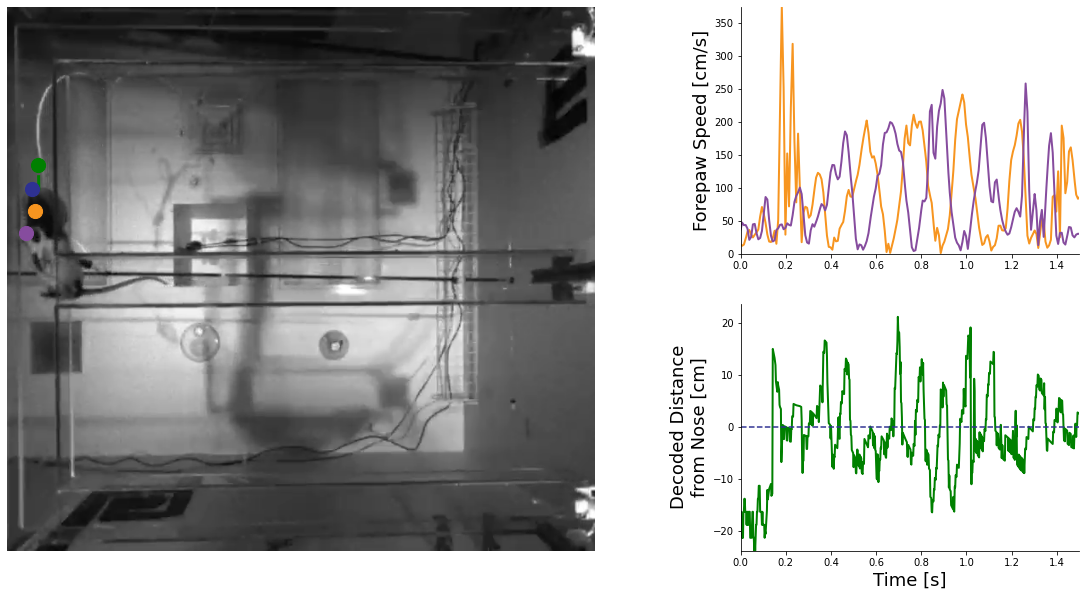

In [402]:
time_slice = slice(22559.000, 22560.500)

movie_name = 'test_with_animal_video4.mp4'
make_movie_with_video3(time_slice, results, data, classifier, video_time, cm_to_pixels,
                       movie_name=movie_name);

Video.from_file(movie_name)

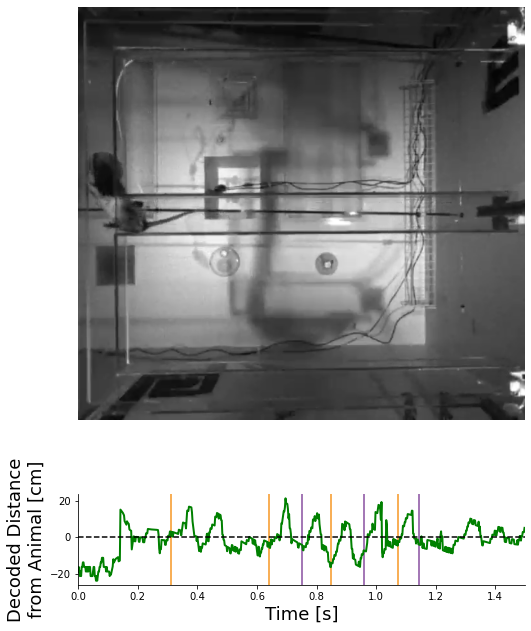

In [439]:
import seaborn as sns

from scipy.io import loadmat


def get_plant_time_ind(forelimb_plant_times, time_slice, decoder_time):
    forelimb_plant_times = forelimb_plant_times.squeeze()
    forelimb_plant_times = forelimb_plant_times[
        (forelimb_plant_times >= time_slice.start) & 
        (forelimb_plant_times <= time_slice.stop)]

    return np.digitize(forelimb_plant_times,
                       np.asarray(decoder_time)[1:-1])


forvideo_data = loadmat('Jaq_d3_ep16_forvideo.mat')
forelimbL_plant_times = forvideo_data['forelimbL_plants']
forelimbR_plant_times = forvideo_data['forelimbR_plants']

forelimbL_plant_time_ind = get_plant_time_ind(
    forelimbL_plant_times, time_slice, results.sel(time=time_slice).time)
forelimbR_plant_time_ind = get_plant_time_ind(
    forelimbR_plant_times, time_slice, results.sel(time=time_slice).time)

fig, axes = plt.subplots(2, 1, figsize=(8, 11),
                         gridspec_kw={"height_ratios": [5, 1]},
                         constrained_layout=False)
axes[0].axis('off')
axes[0].imshow(
    cv2.imread(f'video_images/20190829_Jaq_16_wtrack{video_time_ind[-1]:05d}.png'))


duration = results.sel(time=time_slice).time[-1] - results.sel(time=time_slice).time[0]
bodyparts_to_rgb = {
    'nose': (46, 49, 146),
    'tail': (0, 174, 239), 
    'tailBase': (0, 174, 239),
    'tailMid': (0, 174, 239),
    'tailTip': (0, 174, 239),
    'forepawL': (247, 149, 32),
    'forepawR': (134, 76, 158),
    'hindpawL': (255, 0, 255),
    'hindpawR': (195, 0, 23)
}

for ind in forelimbL_plant_time_ind:
    axes[1].axvline(ind * 0.002, color=np.asarray(bodyparts_to_rgb['forepawL']) / 255)
    
for ind in forelimbR_plant_time_ind:
    axes[1].axvline(ind * 0.002, color=np.asarray(bodyparts_to_rgb['forepawR']) / 255)


axes[1].plot(results.sel(time=time_slice).time - results.sel(time=time_slice).time[0],
    results
    .sel(time=time_slice)
    .rel_distance_from_animal_position_causal,
    color='green',
    linewidth=2,
)
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel('Decoded Distance\nfrom Animal [cm]', fontsize=18)
axes[1].set_xlabel('Time [s]', fontsize=18)
axes[1].set_xlim((0, duration))
sns.despine(ax=axes[1])

In [573]:
from tqdm.auto import tqdm


def get_plant_time_ind(forelimb_plant_times, time_slice, decoder_time):
    forelimb_plant_times = forelimb_plant_times.squeeze()
    forelimb_plant_times = forelimb_plant_times[
        (forelimb_plant_times >= time_slice.start) & 
        (forelimb_plant_times <= time_slice.stop)]

    return np.digitize(forelimb_plant_times, np.asarray(decoder_time)[1:-1])


def make_movie_with_video4(time_slice, results, data, classifier, video_time, forelimbL_plant_times,
                           forelimbR_plant_times,
                           cm_to_pixels, movie_name='video_name.mp4', sampling_frequency=500):
    
    video_mp4 = cv2.VideoCapture('20190829_Jaq_16_wtrack.1.mp4')
    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    ahead_behind_distance = np.asarray(results
                                       .sel(time=time_slice)
                                       .rel_distance_from_animal_position_causal)
    max_ab_distance = np.max(np.abs(ahead_behind_distance))
    duration = results.sel(time=time_slice).time[-1] - results.sel(time=time_slice).time[0]
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    vmax = np.percentile(posterior.values, 99)
    n_frames = posterior.shape[0]
    
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    forelimbL_plant_time_ind = get_plant_time_ind(
        forelimbL_plant_times, time_slice, posterior.time)
    forelimbR_plant_time_ind = get_plant_time_ind(
        forelimbR_plant_times, time_slice, posterior.time)
    
    bodyparts_to_rgb = {
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
    }
    
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = 125//4
    writer = Writer(fps=fps, bitrate=-1)

    fig, axes = plt.subplots(2, 1, figsize=(8, 11),
                             gridspec_kw={"height_ratios": [5, 1]},
                             constrained_layout=False)
    
    # Axis 0
    is_grabbed, frame = video_mp4.read()
    if is_grabbed:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = axes[0].imshow(frame, animated=True, zorder=-1)
    axes[0].axis('off')
        
#     forepawL_dot = axes[0].scatter(
#         [], [], s=200, zorder=102, color=np.asarray(bodyparts_to_rgb['forepawL'])/255,
#         alpha=0.5)
#     forepawR_dot = axes[0].scatter(
#         [], [], s=200, zorder=102, color=np.asarray(bodyparts_to_rgb['forepawR'])/255,
#         alpha=0.5)

    map_dot = axes[0].scatter([], [], s=200, zorder=102, color='green',
                          label='Decoded position')
    (map_line,) = axes[0].plot([], [], 'green', linewidth=3)
    
    # Axes 1
    (ahead_behind_line,) = axes[1].plot([], [], "green", linewidth=2)
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].set_ylabel('Decoded Distance\nfrom Nose [cm]', fontsize=18)
    axes[1].set_xlabel('Time [s]', fontsize=18)
    axes[1].set_xlim((0, duration))
    axes[1].set_ylim((-max_ab_distance, max_ab_distance))
    sns.despine(ax=axes[1])

    def _update_plot(time_ind):
        progress_bar.update()
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)
        
        # Video
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            im.set_array(frame)
        
        if time_ind in forelimbL_plant_time_ind:
#             forepawL_dot.set_offsets(
#                 np.asarray(
#                     position_info[['forepawL_x', 'forepawL_y']]
#                     .iloc[time_ind]) / cm_to_pixels)
            axes[0].scatter(position_info['forepawL_x'].iloc[time_ind] / cm_to_pixels[0],
                            position_info['forepawL_y'].iloc[time_ind] / cm_to_pixels[1],
                            color=np.asarray(bodyparts_to_rgb['forepawL'])/255
                           )            
            axes[1].axvline(time_ind/sampling_frequency,
                            color=np.asarray(bodyparts_to_rgb['forepawL'])/255)
        
        if time_ind in forelimbR_plant_time_ind:
#             forepawR_dot.set_offsets(
#                 np.asarray(
#                     position_info[['forepawR_x', 'forepawR_y']]
#                     .iloc[time_ind]) / cm_to_pixels)
            axes[0].scatter(position_info['forepawR_x'].iloc[time_ind] / cm_to_pixels[0],
                            position_info['forepawR_y'].iloc[time_ind] / cm_to_pixels[1],
                            color=np.asarray(bodyparts_to_rgb['forepawR'])/255
                           )
            axes[1].axvline(time_ind/sampling_frequency,
                            color=np.asarray(bodyparts_to_rgb['forepawR'])/255)

        
        map_dot.set_offsets(map_position[time_ind])
        map_line.set_data(map_position[time_slice, 0],
                          map_position[time_slice, 1])
            
        # Axes 1
        ahead_behind_line.set_data(np.arange(time_ind) / sampling_frequency,
                                   ahead_behind_distance[slice(0, time_ind)])

        return map_dot, map_line, ahead_behind_line, im

    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer)

    return fig, movie

0it [00:00, ?it/s]

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07*Amdat\x00\x00\…

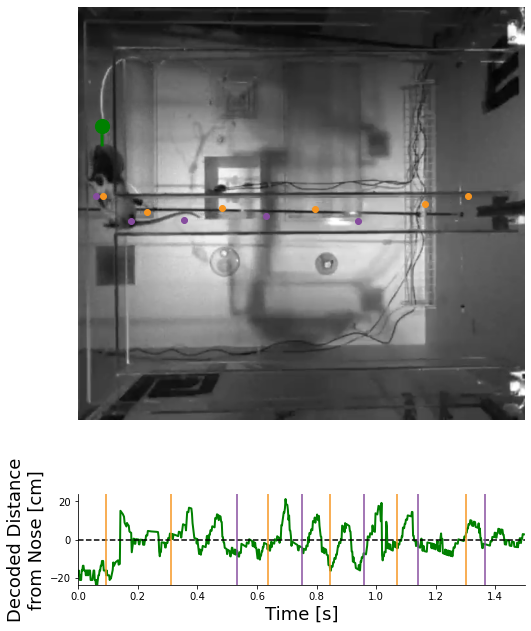

In [574]:
time_slice = slice(22559.0, 22560.5)
movie_name = 'test_with_animal_video5.mp4'

make_movie_with_video4(time_slice, results, data, classifier, video_time, forelimbL_plant_times,
                       forelimbR_plant_times,
                       cm_to_pixels, movie_name=movie_name, sampling_frequency=500)

Video.from_file(movie_name)

In [523]:
time_slice = slice(22559.000, 22559.100)
posterior = results.causal_posterior.sel(time=time_slice).sum('state')
forelimbL_plant_time_ind = get_plant_time_ind(
    forelimbL_plant_times, time_slice, posterior.time)
forelimbL_plant_time_ind

[22559.09608697]


array([47])

In [522]:
def get_plant_time_ind(forelimb_plant_times, time_slice, decoder_time):
    forelimb_plant_times = forelimb_plant_times.squeeze()
    forelimb_plant_times = forelimb_plant_times[
        (forelimb_plant_times >= time_slice.start) & 
        (forelimb_plant_times <= time_slice.stop)]

    return np.digitize(forelimb_plant_times, np.asarray(decoder_time)[1:-1])

In [498]:
time_slice

slice(22559.0, 22559.1, None)

In [524]:
time_slice = slice(22559.0, 22559.1)

forelimb_plant_times = forelimbL_plant_times.copy()
posterior = results.causal_posterior.sel(time=time_slice).sum('state')
decoder_time = posterior.time.copy()


forelimb_plant_times = forelimb_plant_times.squeeze()
forelimb_plant_times = forelimb_plant_times[
    (forelimb_plant_times >= time_slice.start) & 
    (forelimb_plant_times <= time_slice.stop)]
forelimb_plant_times, np.digitize(forelimb_plant_times, np.asarray(decoder_time)[1:-1]), get_plant_time_ind(forelimbL_plant_times, time_slice, posterior.time)

[22559.09608697]


(array([22559.09608697]), array([47]), array([47]))

In [512]:
np.digitize([-0.5], np.arange(10)[1:-1])

array([0])

In [509]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [462]:
forelimbL_plant_times.squeeze()

array([22421.91328756, 22422.13726067, 22422.48122191, 22422.72118728,
       22422.96915487, 22423.21712143, 22423.52108649, 22423.8490452 ,
       22446.67818334, 22446.92615015, 22447.12613012, 22447.3900997 ,
       22447.63006502, 22447.86203703, 22483.36158025, 22483.89751721,
       22484.16947706, 22484.37745832, 22484.59343014, 22484.8094021 ,
       22485.11336743, 22485.63329376, 22510.27820531, 22510.55017623,
       22510.75014571, 22510.9501264 , 22511.1740998 , 22511.39007205,
       22511.59804315, 22511.87800479, 22512.2459599 , 22537.16283668,
       22537.51478857, 22537.77875744, 22537.98672782, 22538.20269983,
       22539.13058869, 22558.58415058, 22558.77612934, 22558.93610294,
       22559.09608697, 22559.31205922, 22559.64001793, 22559.84798879,
       22560.07196242, 22560.3039372 , 22560.51990945, 22560.85586572,
       22578.90159832, 22579.1015783 , 22579.4055329 , 22579.67750362,
       22579.88547415, 22580.09345537, 22581.00534074, 22601.72273774,
      